In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, BatchNormalization,
                                     Activation, Dropout, Flatten, Dense, GlobalAveragePooling2D)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# ----------------------------
# 1. Model Architecture: ScriptNet
# ----------------------------

def build_scriptnet_enhanced(input_shape=(64, 64, 1), num_classes=83):
    inputs = Input(shape=input_shape, name='input_layer')

    # Block 1
    x = Conv2D(64, (3, 3), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)

    # Block 2
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)

    # Block 3
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.4)(x)

    # Block 4 - Deeper features
    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)

    # Fully connected layers
    x = Dense(1024)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)

    outputs = Dense(num_classes, activation='softmax', name='output_layer')(x)

    model = Model(inputs=inputs, outputs=outputs, name='ScriptNetEnhancedV2')
    return model


2025-05-30 16:22:14.021724: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748622134.205901      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748622134.260096      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [7]:
# ----------------------------
# 2. Data Loading: BanglaLekha-Isolated
# ----------------------------
# Replace this with your full Google Drive path if needed
dataset_path = "/kaggle/input/bangla-lekha-isolated-dataset/BanglaLekha-Isolated/Images/"

input_shape = (64, 64, 1)
batch_size = 64
epochs = 30
num_classes = 84  # Update if using fewer classes

# ImageDataGenerator with augmentation for training and only rescaling for validation
datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    validation_split=0.2,

    #Augmentation settings for handwritten characters
    rotation_range=10,          # small rotations
    zoom_range=0.1,             # slight zoom in/out
    width_shift_range=0.1,      # horizontal shift
    height_shift_range=0.1,     # vertical shift
    shear_range=0.1,            # slight shear transformation
    fill_mode='nearest'         # fill pixels after transformation
)

train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(64, 64),
    color_mode='grayscale',
    class_mode='sparse',
    batch_size=batch_size,
    subset='training',
    shuffle=True,
    seed=42
)

val_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(64, 64),
    color_mode='grayscale',
    class_mode='sparse',
    batch_size=batch_size,
    subset='validation',
    shuffle=False,
    seed=42
)

Found 132914 images belonging to 84 classes.
Found 33191 images belonging to 84 classes.


In [8]:
# ----------------------------
# 3. Compile Model
# ----------------------------
model = build_scriptnet_enhanced(input_shape=input_shape, num_classes=num_classes)
model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "ScriptNetEnhancedV2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 64, 64, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 64, 64, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_9 (Activation)            │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_10 (Activation)           │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_11 (Activation)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_12 (Activation)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 16, 16, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │              

 Total params: 5,307,412 (20.25 MB)

 Trainable params: 5,301,524 (20.22 MB)

 Non-trainable params: 5,888 (23.00 KB)

In [9]:
# ----------------------------
# 4. Callbacks
# ----------------------------
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=8, min_delta=0.001, restore_best_weights=True),
    ModelCheckpoint("scriptnet_banglalekha_best.h5", monitor="val_accuracy", save_best_only=True, verbose=1)
]

epochs=100

# ----------------------------
# 5. Train Model
# ----------------------------
steps_per_epoch = np.ceil(train_generator.samples / batch_size).astype(int)
validation_steps = np.ceil(val_generator.samples / batch_size).astype(int)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks
)

Epoch 1/100


I0000 00:00:1748624173.531769     115 service.cc:148] XLA service 0x7c3ae4003150 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748624173.532565     115 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1748624173.532586     115 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1748624174.439634     115 cuda_dnn.cc:529] Loaded cuDNN version 90300


   1/2077 ━━━━━━━━━━━━━━━━━━━━ 13:19:35 23s/step - accuracy: 0.0156 - loss: 5.2297

I0000 00:00:1748624187.545433     115 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2077/2077 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.4010 - loss: 2.4177
Epoch 1: val_accuracy improved from -inf to 0.87837, saving model to scriptnet_banglalekha_best.h5
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 778s 363ms/step - accuracy: 0.4011 - loss: 2.4173 - val_accuracy: 0.8784 - val_loss: 0.3988 - learning_rate: 0.0010
Epoch 2/100
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.8072 - loss: 0.6835
Epoch 2: val_accuracy improved from 0.87837 to 0.93495, saving model to scriptnet_banglalekha_best.h5
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 375s 181ms/step - accuracy: 0.8072 - loss: 0.6835 - val_accuracy: 0.9350 - val_loss: 0.2310 - learning_rate: 0.0010
Epoch 3/100
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.8672 - loss: 0.4779
Epoch 4: val_accuracy improved from 0.94233 to 0.95592, saving model to scriptnet_banglalekha_best.h5
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 284s 137ms/step - accuracy: 0.8672 - loss: 0.4779 - val_accuracy: 0.9559 - val_loss: 0.1604 - learning_rate: 0.

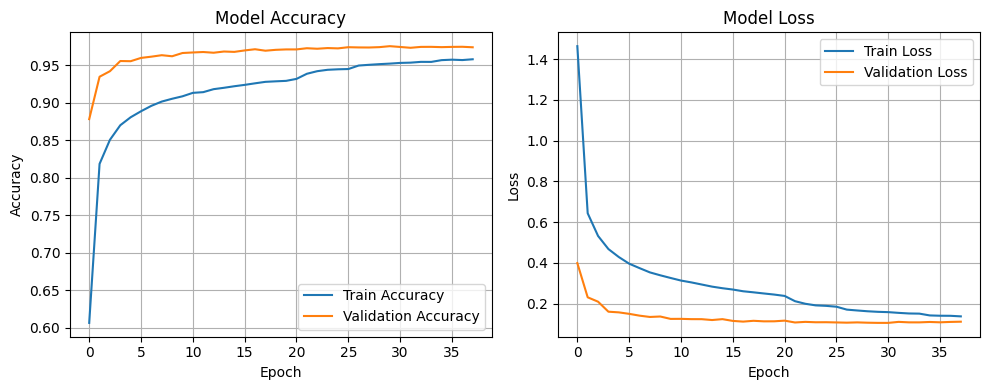

In [10]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

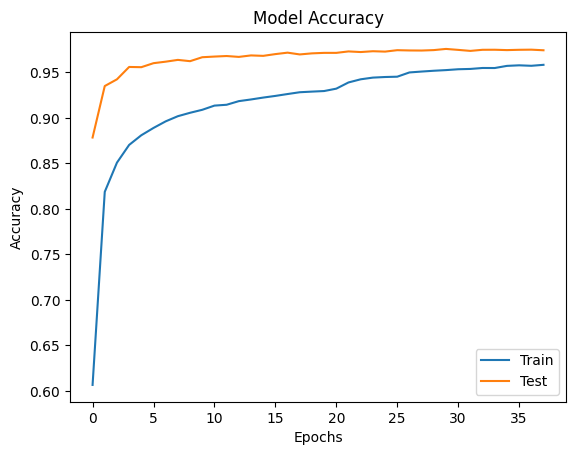

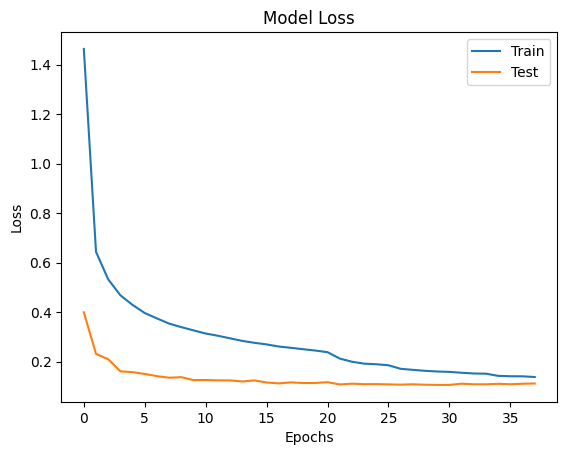

In [11]:
# plot the convergence, in terms of accuracy and loss, of ScriptNet
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

519/519 ━━━━━━━━━━━━━━━━━━━━ 54s 101ms/step


<Figure size 1200x1200 with 0 Axes>

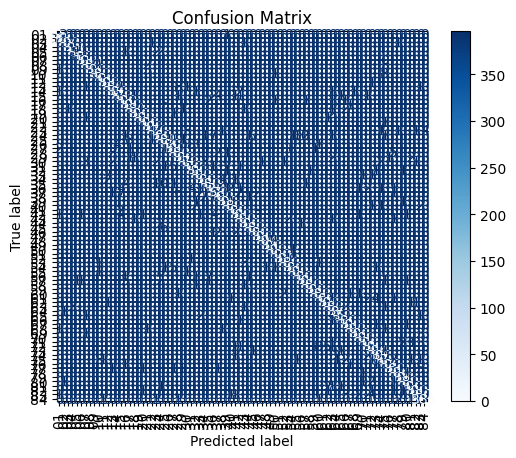

In [12]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict labels
y_pred_probs = model.predict(val_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# True labels
y_true = val_generator.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_generator.class_indices.keys())
plt.figure(figsize=(12, 12))
disp.plot(cmap='Blues', xticks_rotation=90)
plt.title("Confusion Matrix")
plt.show()

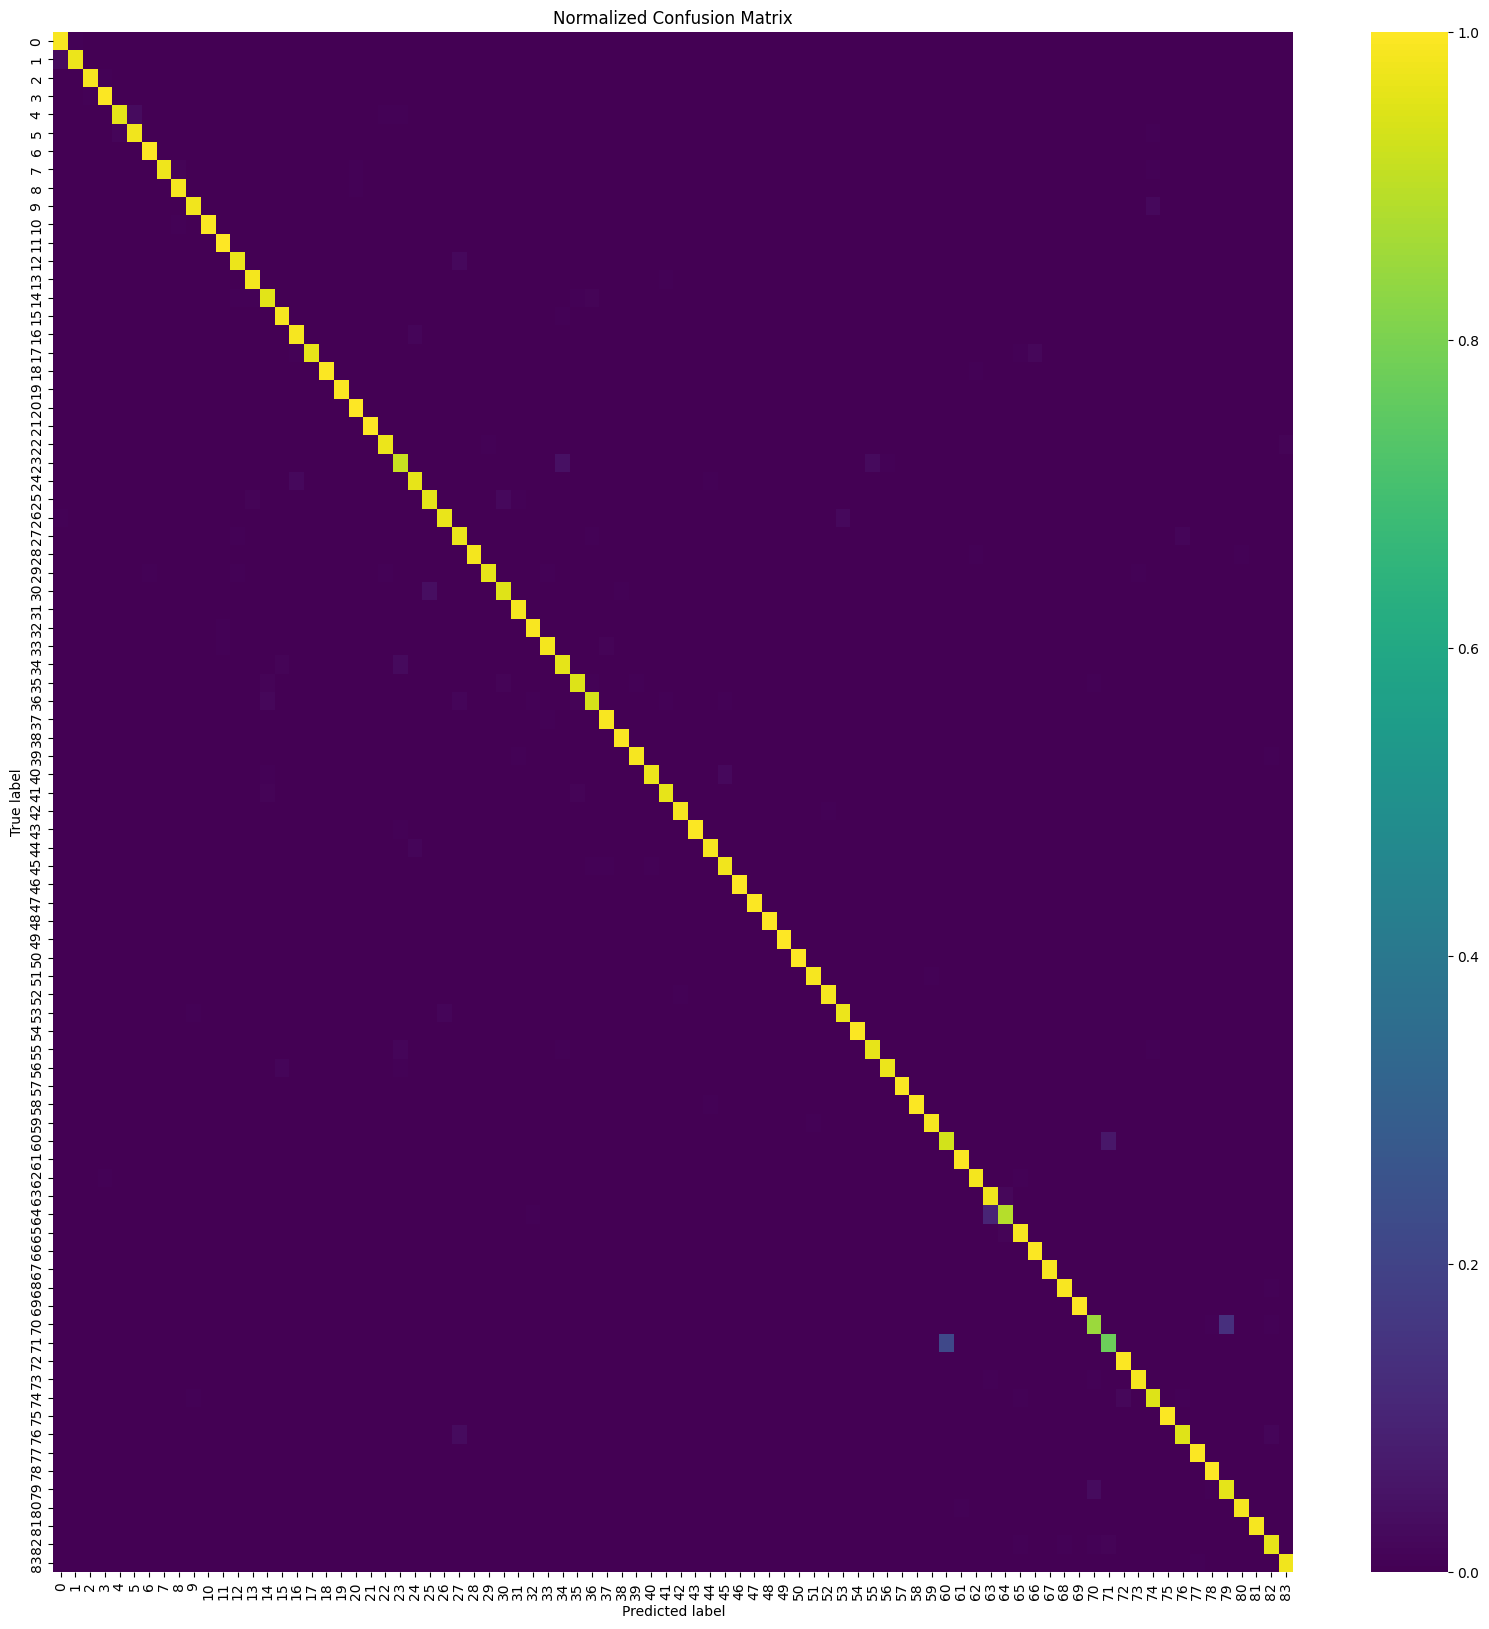

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# true and predicted labels
cm = confusion_matrix(y_true, y_pred, labels=range(84))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(20, 20))
sns.heatmap(cm_normalized, annot=False, cmap='viridis')
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


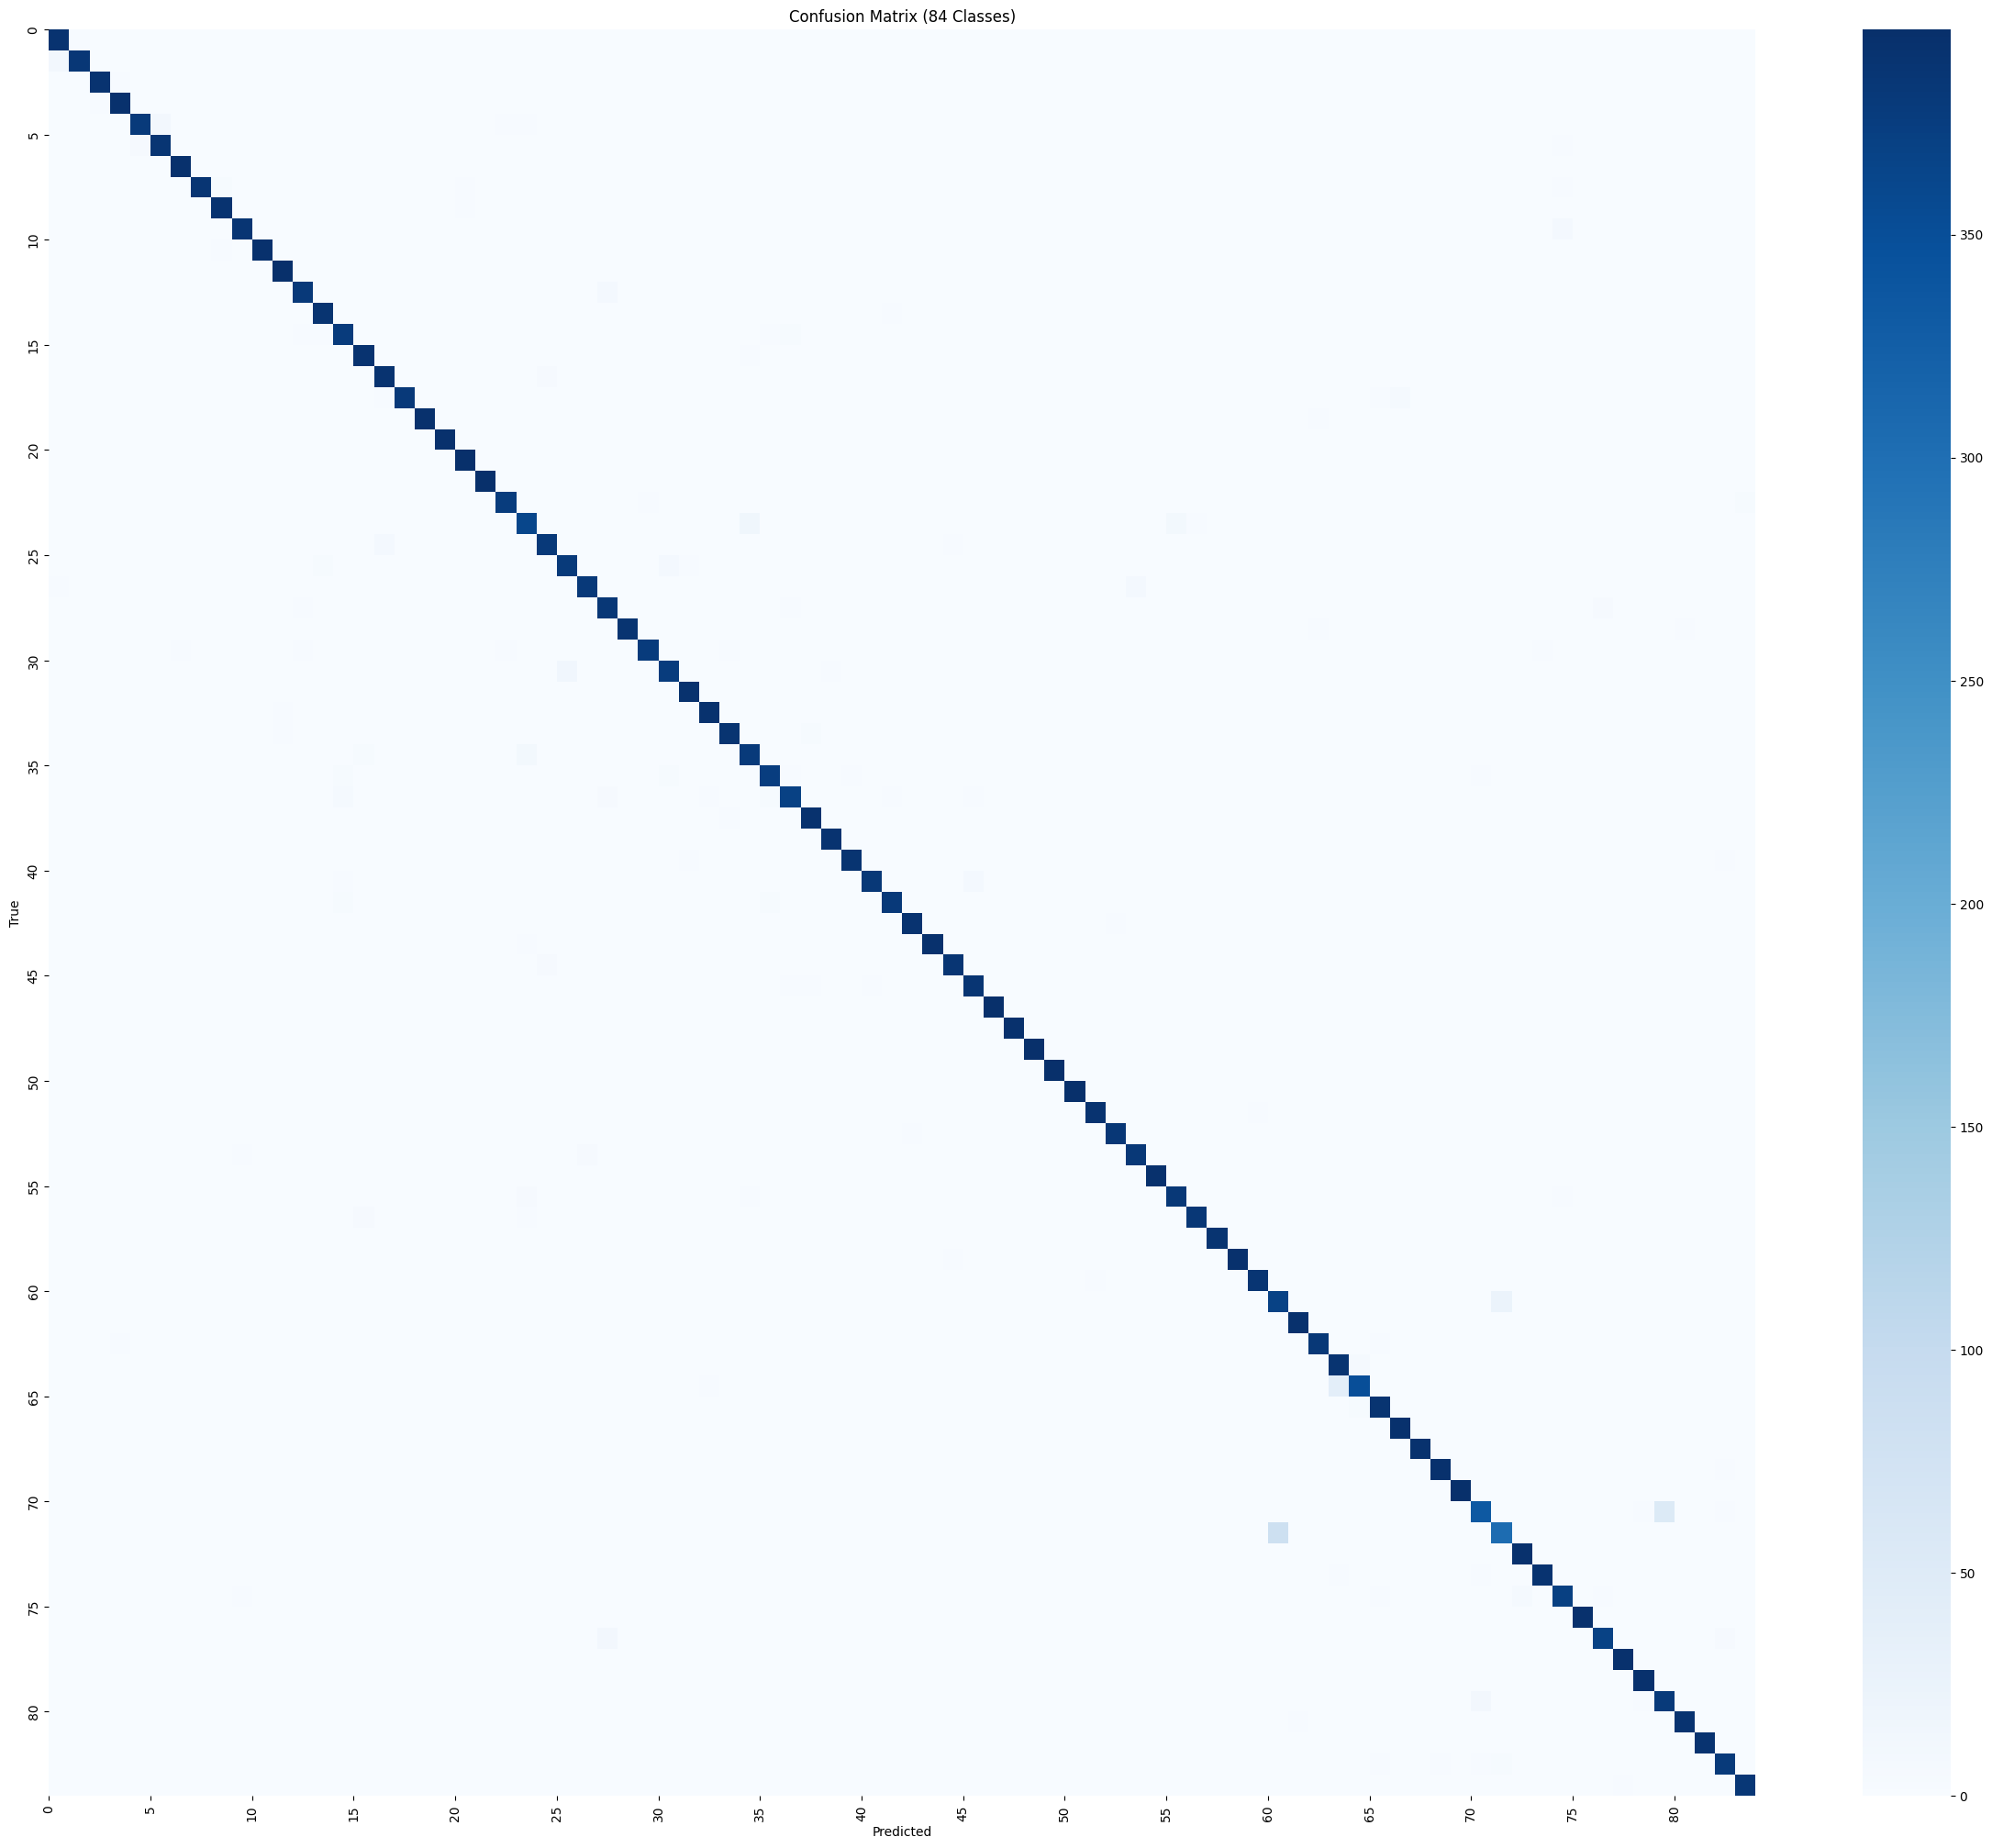

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(30, 25))  # Bigger figure
sns.heatmap(cm, annot=False, cmap='Blues', cbar=True)
plt.title('Confusion Matrix (84 Classes)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(ticks=range(0, 84, 5), labels=range(0, 84, 5), rotation=90)  # Sparse ticks
plt.yticks(ticks=range(0, 84, 5), labels=range(0, 84, 5))
plt.show()


In [15]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

# Predict and true labels (already obtained previously)
y_pred_probs = model.predict(val_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = val_generator.classes
class_names = list(val_generator.class_indices.keys())

# Print classification report
report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
print("📋 Classification Report:\n")
print(report)

# Extract and print macro, weighted scores
precision_macro = precision_score(y_true, y_pred, average='macro')
recall_macro = recall_score(y_true, y_pred, average='macro')
f1_macro = f1_score(y_true, y_pred, average='macro')

precision_weighted = precision_score(y_true, y_pred, average='weighted')
recall_weighted = recall_score(y_true, y_pred, average='weighted')
f1_weighted = f1_score(y_true, y_pred, average='weighted')

print("🔢 Macro Scores")
print(f"Precision (Macro): {precision_macro:.4f}")
print(f"Recall (Macro):    {recall_macro:.4f}")
print(f"F1-score (Macro):  {f1_macro:.4f}")

print("\n🔢 Weighted Scores")
print(f"Precision (Weighted): {precision_weighted:.4f}")
print(f"Recall (Weighted):    {recall_weighted:.4f}")
print(f"F1-score (Weighted):  {f1_weighted:.4f}")


519/519 ━━━━━━━━━━━━━━━━━━━━ 50s 96ms/step
📋 Classification Report:

              precision    recall  f1-score   support

          01     0.9652    0.9823    0.9737       395
          02     0.9823    0.9798    0.9810       396
          03     0.9899    0.9924    0.9912       395
          04     0.9850    0.9949    0.9899       396
          05     0.9795    0.9646    0.9720       396
          06     0.9772    0.9747    0.9760       396
          07     0.9825    0.9975    0.9899       394
          08     0.9898    0.9773    0.9835       397
          09     0.9874    0.9924    0.9899       396
          10     0.9751    0.9874    0.9812       396
          11     0.9899    0.9949    0.9924       396
          12     0.9875    0.9975    0.9925       396
          13     0.9673    0.9796    0.9735       393
          14     0.9798    0.9823    0.9811       396
          15     0.9567    0.9519    0.9543       395
          16     0.9656    0.9924    0.9788       396
          17

In [16]:
history2 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks
)

Epoch 1/5
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.9544 - loss: 0.1521
Epoch 1: val_accuracy did not improve from 0.97575
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 515s 248ms/step - accuracy: 0.9544 - loss: 0.1521 - val_accuracy: 0.9751 - val_loss: 0.1072 - learning_rate: 6.2500e-05
Epoch 2/5
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.9556 - loss: 0.1463
Epoch 2: val_accuracy did not improve from 0.97575
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 442s 213ms/step - accuracy: 0.9556 - loss: 0.1463 - val_accuracy: 0.9754 - val_loss: 0.1070 - learning_rate: 6.2500e-05
Epoch 3/5
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9571 - loss: 0.1439
Epoch 3: val_accuracy did not improve from 0.97575
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 412s 198ms/step - accuracy: 0.9571 - loss: 0.1439 - val_accuracy: 0.9745 - val_loss: 0.1073 - learning_rate: 6.2500e-05
Epoch 4/5
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.9573 - loss: 0.1461
Epoch 4: val_accuracy did not improve 